# 브루클린 판매데이터분석 연습과제[3] -- 장바구니 연관성 분석

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.polynomial.polynomial import polyfit

# define random jitter
def rjitt(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def rjitt5(arr):
    stdev = .07*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

# custom min max scaler
def mnmx_scl(vec):
    vec = (vec-vec.min())/(vec.max()-vec.min())
    return(vec)

 # 값별 인원수와 구성비를 dataframe 형태로 출력하는 함수
def cntnpcnt(x):
    # x is supposed to be a pandas series
    dfx = pd.DataFrame(x)
    dfx['recCnt'] = 1
    dfx = dfx.groupby(dfx.columns[0]).count().reset_index()
    dfx['pcntrecCnt'] = dfx.recCnt/dfx.recCnt.sum() *100
    return(dfx)


# local data path
dataPath = 'D:/YONG/myPydata/' # 생성위치는 사용자 지정

import matplotlib.font_manager

    
# matplotlib 에서 한글을 표시하기 위한 설정
font_name = matplotlib.font_manager.FontProperties(
                fname="c:/Windows/Fonts/malgun.ttf"  # 윈도우즈의 한글 폰트 위치를 지정
            ).get_name()
matplotlib.rc('font', family=font_name)

matplotlib.rcParams['axes.unicode_minus'] = False #  음수를 나타내는 '-' 부호가 정상 표시되도록



## 데이터셋 불러오기

In [2]:
itemmast = pd.read_csv(dataPath + 'brk_itemmast01.csv', encoding='euc-kr')
itemmast = itemmast.drop(itemmast.columns[0], axis=1)

sales = pd.read_csv(dataPath + 'brk_salesmast01.csv', encoding='euc-kr')
sales = sales.drop(sales.columns[0], axis=1)

custmast = pd.read_csv(dataPath + 'brk_custmast01.csv', encoding='euc-kr')
custmast = custmast.drop(custmast.columns[0], axis=1)

### 장바구니 구매연관성 분석 방향

- 최근 1년 고객별 장바구니 분석 실시
- 계절별 별도 상품군단위 영수증별 장바구니 분석 (계절별 연도별 별도 분석 필요)


#### 선행분석 - 상품체계 분석을 통한 분석대상 기준 설정

In [3]:
# 상품코드 구조 검토

sa1tmp = sales[sales.datea>='2020-01-01']
baseItemFeats = ['item_id', 'item_id_detcode', 'lcat','scat','season','unit_prc']
sa1tmp.sort_values('item_id')[baseItemFeats].drop_duplicates().tail(20)

,item_id,item_id_detcode,lcat,scat,season,unit_prc
31876,SH1008808,108,여성캐주얼,바지,FW,35000
33871,SH1008809,109,여성캐주얼,바지,FW,35000
21583,SH1008901,101,남성캐주얼,셔츠,AS,80000
9825,SH1008901,101,남성캐주얼,셔츠,AS,64000
23473,SH1008902,102,남성캐주얼,셔츠,AS,80000
28073,SH1008902,102,남성캐주얼,셔츠,AS,64000
13502,SH1008903,103,남성캐주얼,셔츠,AS,80000
9800,SH1008903,103,남성캐주얼,셔츠,AS,64000
27722,SH1008904,104,남성캐주얼,셔츠,AS,80000
10558,SH1008904,104,남성캐주얼,셔츠,AS,64000


- item_id_detcode 는 단품을 구별하기 위한 순번
<br><br>
- item_id 코드 구조  = { ( 0~ 1 ) : 브랜드구분코드 ,  ( 2~ 6 ) : 상품번호 , ( 7~ 8 ) : 단품순번 } 

In [4]:
salesTmp = sales[['item_id']].copy()
salesTmp['item_idA'] = salesTmp.item_id.str.slice(0,7)

# 상품번호별 판매건수 분포 확인
# 상품번호 단위로 보면 총 130종의 기간 중 판매된 상품 존재
salesTmp['item_idA'].value_counts().reset_index()

,index,item_idA
0,SH10089,878
1,SH10087,781
2,SH10038,691
3,SH10090,683
4,SH10057,673
...,...,...
125,ES20022,57
126,ES20044,52
127,ES20038,49
128,ES20037,41


In [5]:
# 단품구분코드는 장바구니 분석에서는 사용하지 않음

baseItemFeats = ['item_id', 'lcat','scat','season','unit_prc']

# 상품범호 단위의 상품기본속성 테이블 준비
itemmastA = itemmast[baseItemFeats].drop_duplicates().copy()
itemmastA['item_id'] = itemmastA.item_id.str.slice(0,7)

# 주요속성을 묶어서 상품의 의미를 파악할 수 있는 컬럼 생성
# 장바구니 분석에서 itemTitle을 기준으로 사용
itemmastA['itemTitle'] = itemmastA.item_id.str.slice(0,2) + itemmastA.lcat + '_' + itemmastA.scat + itemmastA.season + (itemmastA.unit_prc/1000).astype(int).astype(str)
itemmastA = itemmastA.drop_duplicates()
itemmastA

,item_id,lcat,scat,season,unit_prc,itemTitle
0,ES20005,여성캐주얼,재킷,AS,155000,ES여성캐주얼_재킷AS155
6,ES20006,여성캐주얼,바지,FW,90000,ES여성캐주얼_바지FW90
15,ES20007,여성캐주얼,바지,SS,100000,ES여성캐주얼_바지SS100
24,ES20008,여성캐주얼,셔츠,AS,100000,ES여성캐주얼_셔츠AS100
33,ES20009,여성캐주얼,바지,FW,90000,ES여성캐주얼_바지FW90
...,...,...,...,...,...,...
924,SH10086,코트,코트,FW,265000,SH코트_코트FW265
928,SH10087,여성캐주얼,바지,SS,35000,SH여성캐주얼_바지SS35
937,SH10088,여성캐주얼,바지,FW,35000,SH여성캐주얼_바지FW35
946,SH10089,남성캐주얼,셔츠,AS,80000,SH남성캐주얼_셔츠AS80


- 고려사항 : 상품군별로 가격대를 각각 구분한 코드를 설정한다면 고가, 중가, 저가 구조의 분류 단위로 분석 가능할 것

## 1년간 고객별 분석 데이터 준비

###  데이터 준비

In [6]:
# 연관성 규칙 생성을 위해 list format (i.e. wide format)으로 변환
# apriori 알고리즘이 요구하는 형식으로

# 2020년 1월 이후 데이터만 사용 
sa1 = sales[sales.datea>='2020-01-01']
print(sa1.shape)

sa3 = sa1[['cust_id','item_id']].copy()
sa3['item_id'] = sa3['item_id'].str.slice(0,7)
sa3 = sa3.drop_duplicates().copy()

# 최소한의 빈도가 있는 상품으로 분석대상 한정
itemCntdf = cntnpcnt(sa3.item_id) # 사용자정의함수로 상품별 빈도 집계
frqItems = itemCntdf[itemCntdf.recCnt>=5].item_id
sa3 = sa3[sa3.item_id.isin(frqItems)]

# 구매한 상품이 하나 뿐이라면 다른 상품과의 연관성 도출에는 무의미하므로 고객 제외
tmpsa3custs = sa3[['cust_id','item_id']].groupby('cust_id').count().reset_index()
sa3 = sa3[sa3.cust_id.isin(tmpsa3custs[tmpsa3custs.item_id>1].cust_id)]



(20014, 19)


In [7]:
# 고객별 구매상품리스트 데이터 준비

# 고객별 구매상품 리스트를 저장할 빈 리스트
tmparr = []
# 고객리스트
ucusts = list(sa3.cust_id.unique())
# 고객수
numcusts = len(ucusts)

# 고객별로 구매상품 리스트를 추가
for x in ucusts:
    tmpcust_items = list(sa3[sa3.cust_id==x].item_id.values)
    tmparr.append(tmpcust_items)
    
# Check the formatted
print(np.array(tmparr).shape)

# 저장이 정상적으로 되었는지 일부 확인
np.array(tmparr[:10])

(3506,)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7560\2647728617.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(np.array(tmparr).shape)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7560\2647728617.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(tmparr[:10])


array([list(['SH10087', 'SH10063', 'SH10013']),
       list(['SH10080', 'SH10069']), list(['ES20005', 'SH10018']),
       list(['SH10017', 'SH10031']), list(['ES20033', 'SH10007']),
       list(['SH10007', 'SH10037']), list(['ES20026', 'SH10049']),
       list(['SH10082', 'ES20031']),
       list(['SH10064', 'SH10006', 'SH10036']),
       list(['SH10086', 'SH10008'])], dtype=object)

### 고객별 1년 상품간 구매연관성 규칙 도출

In [8]:
# 알고리즘 적용 연관성 규칙 추출

from apyori import apriori

rules = apriori(tmparr, min_support = 0.0001, min_confidence = 0.02, max_length = 2,
               #  min_lift = 1.05
               )

# Listing the resulting Rules
results = list(rules)

print('생성된 규칙 확인(일부) : \n', results[:500][497:])

print("\nnumber of rules : " + str(len(results)) + '\n')
num_rules = len(results)


생성된 규칙 확인(일부) : 
 [RelationRecord(items=frozenset({'ES20018', 'SH10088'}), support=0.0002852253280091272, ordered_statistics=[OrderedStatistic(items_base=frozenset({'ES20018'}), items_add=frozenset({'SH10088'}), confidence=0.05555555555555555, lift=1.0197789412449099)]), RelationRecord(items=frozenset({'SH10089', 'ES20018'}), support=0.0002852253280091272, ordered_statistics=[OrderedStatistic(items_base=frozenset({'ES20018'}), items_add=frozenset({'SH10089'}), confidence=0.05555555555555555, lift=0.8813474107591754)]), RelationRecord(items=frozenset({'ES20021', 'ES20019'}), support=0.0002852253280091272, ordered_statistics=[OrderedStatistic(items_base=frozenset({'ES20019'}), items_add=frozenset({'ES20021'}), confidence=0.03333333333333333, lift=4.029885057471264), OrderedStatistic(items_base=frozenset({'ES20021'}), items_add=frozenset({'ES20019'}), confidence=0.03448275862068965, lift=4.0298850574712635)])]

number of rules : 3228



In [9]:
column_names = ["ante", "cnsq", "conf","supp","lift"]
ruledf = pd.DataFrame(columns = column_names)

# Print rules one by one
for i in range(0, num_rules):
    result = results[i]
    # print(result)
    supp = int(result.support*10000)/100
    conf = int(result.ordered_statistics[0].confidence *1000)/10
    lift = int(result.ordered_statistics[0].lift *100)/100,
    ante = ''.join([x+' ' for x in result.ordered_statistics[0].items_add]).strip()
    cnsq = ''.join([x+' ' for x in result.ordered_statistics[0].items_base]).strip()
    
    if ante!='':
        # print only 30 rules
        if i<30:
            print("{ "+str(ante)+ " ==>  " + str(cnsq)  +
                  " } [ conf = " + str(conf) + "%,"+ " supp = "+str(supp)+"%, " +
                  " lift = "+str(list(lift)[0])+"]")        
            
        # insert raws into a container df    
        ruledf.loc[i] = [ante, cnsq, conf, supp, list(lift)[0]]
    
ruledf.sort_values('lift').tail(20)

{ ES20007 ==>   } [ conf = 2.3%, supp = 2.31%,  lift = 1.0]
{ SH10003 ==>   } [ conf = 2.4%, supp = 2.42%,  lift = 1.0]
{ SH10006 ==>   } [ conf = 2.1%, supp = 2.11%,  lift = 1.0]
{ SH10007 ==>   } [ conf = 2.1%, supp = 2.13%,  lift = 1.0]
{ SH10010 ==>   } [ conf = 2.1%, supp = 2.16%,  lift = 1.0]
{ SH10012 ==>   } [ conf = 3.8%, supp = 3.82%,  lift = 1.0]
{ SH10016 ==>   } [ conf = 2.2%, supp = 2.22%,  lift = 1.0]
{ SH10017 ==>   } [ conf = 2.6%, supp = 2.62%,  lift = 1.0]
{ SH10020 ==>   } [ conf = 2.3%, supp = 2.31%,  lift = 1.0]
{ SH10023 ==>   } [ conf = 2.7%, supp = 2.76%,  lift = 1.0]
{ SH10029 ==>   } [ conf = 2.1%, supp = 2.13%,  lift = 1.0]
{ SH10030 ==>   } [ conf = 2.7%, supp = 2.76%,  lift = 1.0]
{ SH10031 ==>   } [ conf = 2.6%, supp = 2.68%,  lift = 1.0]
{ SH10033 ==>   } [ conf = 2.3%, supp = 2.39%,  lift = 1.0]
{ SH10034 ==>   } [ conf = 2.2%, supp = 2.28%,  lift = 1.0]
{ SH10035 ==>   } [ conf = 2.2%, supp = 2.28%,  lift = 1.0]
{ SH10038 ==>   } [ conf = 3.1%, supp = 

,ante,cnsq,conf,supp,lift
1048,SH10024,ES20036,12.5,0.02,8.11
225,ES20019,ES20009,7.1,0.02,8.34
224,ES20011,ES20009,7.1,0.02,8.34
366,ES20033,ES20014,11.7,0.05,8.41
250,ES20018,ES20010,4.3,0.02,8.46
633,ES20027,ES20024,3.4,0.02,8.63
598,ES20033,ES20022,12.5,0.02,8.94
1057,SH10079,ES20036,25.0,0.05,9.32
1050,SH10031,ES20036,25.0,0.05,9.32
252,ES20020,ES20010,4.3,0.02,9.52


- 규칙리스트에서 (ruleset 데이터프레임) ante : antecedent 조건부 ; cnsq : consequent 결과부
- 즉 <바지를 사면(ante) 셔츠도(cnsq) 산다> 의 형식으로 규칙 구성
<br><br>
- conf는 confidence 규칙이 성립할 확률 ; supp는 support 규칙이 해당되는 건의 수(비율)


### 생성된 규칙의 분포 확인

(3228, 5)


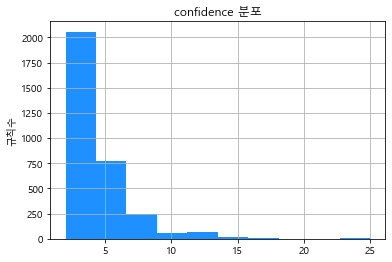

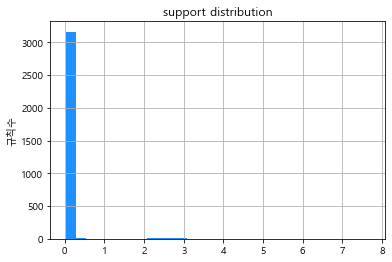

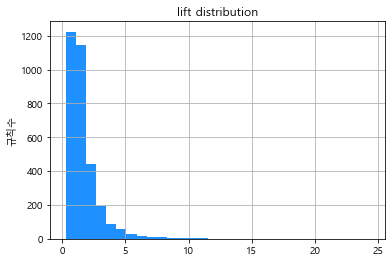

In [10]:
print(ruledf.shape) # 생성된 규칙 건수 표시

ruledf.conf.hist(bins=10, color='dodgerblue')
plt.title('confidence 분포')
plt.ylabel('규칙수')
plt.show()

ruledf.supp.hist(bins=30, color='dodgerblue')
plt.title('support distribution')
plt.ylabel('규칙수')
plt.show()

ruledf.lift.hist(bins=30, color='dodgerblue')
plt.title('lift distribution')
plt.ylabel('규칙수')
plt.show()

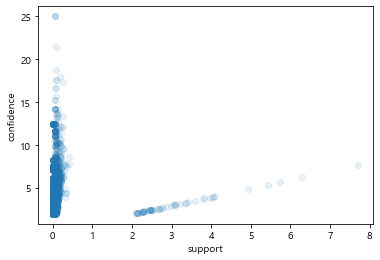

In [11]:
# confidence와 support간의 관계

plt.scatter(ruledf.supp, ruledf.conf, alpha=0.1)
plt.xlabel('support')
plt.ylabel('confidence')
plt.show()

- support가 높은 규칙들의 경우 통상 confidence가 높지 않음
- 추출된 규칙들에서도 support가 매우 낮고 confidence는 다양한 경우가 다수 존재함

In [12]:
# 전체중 중요도 높은 관심있는 범위의 규칙만 추출 (필요시 반복적인 조절 가능)

ruledfSub = ruledf[(ruledf.conf>5) & (ruledf.supp>0.1) & (ruledf.lift>3)].sort_values('lift')
ruledfSub 

,ante,cnsq,conf,supp,lift
2571,SH10069,SH10041,12.1,0.22,3.05
1725,SH10023,SH10013,8.4,0.14,3.06
1925,SH10032,SH10019,6.1,0.11,3.08
2575,SH10082,SH10041,7.5,0.14,3.08
2880,SH10078,SH10056,11.7,0.11,3.10
2168,SH10040,SH10027,9.9,0.11,3.24
2076,SH10030,SH10024,9.2,0.14,3.34
1926,SH10034,SH10019,7.6,0.14,3.37
2082,SH10049,SH10024,7.4,0.11,3.71
1945,SH10082,SH10019,10.7,0.19,4.39


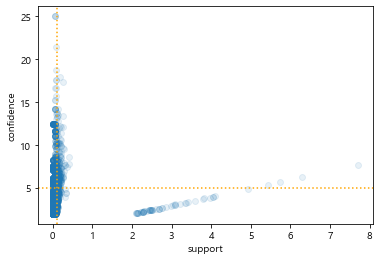

In [13]:
# 추출한 규칙의 범위 시각적 확인

plt.scatter(ruledf.supp, ruledf.conf, alpha=0.1)
plt.xlabel('support')
plt.ylabel('confidence')
plt.axvline(0.1, color='orange', linestyle=':')
plt.axhline(5, color='orange', linestyle=':')
plt.show()

In [14]:
dfitemTitle = itemmastA[['item_id','itemTitle']]
rulsnAtts = ruledfSub.sort_values(['conf','supp'], ascending=False).merge(dfitemTitle, how='left', left_on='ante', right_on='item_id')
rulsnAtts = rulsnAtts.merge(dfitemTitle, how='left', left_on='cnsq', right_on='item_id')

rulsnAtts.sort_values('itemTitle_x')[['ante','cnsq','supp','lift','itemTitle_x','itemTitle_y']]

,ante,cnsq,supp,lift,itemTitle_x,itemTitle_y
4,SH10078,SH10056,0.11,3.10,SH남성캐주얼_셔츠AS80,SH남성캐주얼_셔츠FW80
10,SH10034,SH10019,0.14,3.37,SH남성캐주얼_셔츠AS80,SH여성캐주얼_재킷AS180
11,SH10073,SH10035,0.17,5.05,SH남성캐주얼_재킷FW135,SH남성캐주얼_바지SS70
6,SH10071,SH10037,0.17,4.53,SH남성캐주얼_재킷SS190,SH남성캐주얼_재킷SS125
5,SH10082,SH10019,0.19,4.39,SH여성캐주얼_바지FW60,SH여성캐주얼_재킷AS180
12,SH10082,SH10041,0.14,3.08,SH여성캐주얼_바지FW60,SH여성캐주얼_바지FW70
14,SH10032,SH10019,0.11,3.08,SH여성캐주얼_바지FW60,SH여성캐주얼_재킷AS180
7,SH10040,SH10027,0.11,3.24,SH여성캐주얼_바지SS145,SH코트_코트FW230
2,SH10030,ES20011,0.11,4.81,SH여성캐주얼_바지SS70,ES여성캐주얼_바지AS65
3,SH10069,SH10041,0.22,3.05,SH여성캐주얼_바지SS70,SH여성캐주얼_바지FW70


### 연관성 네트워크 다이어그램 시각화

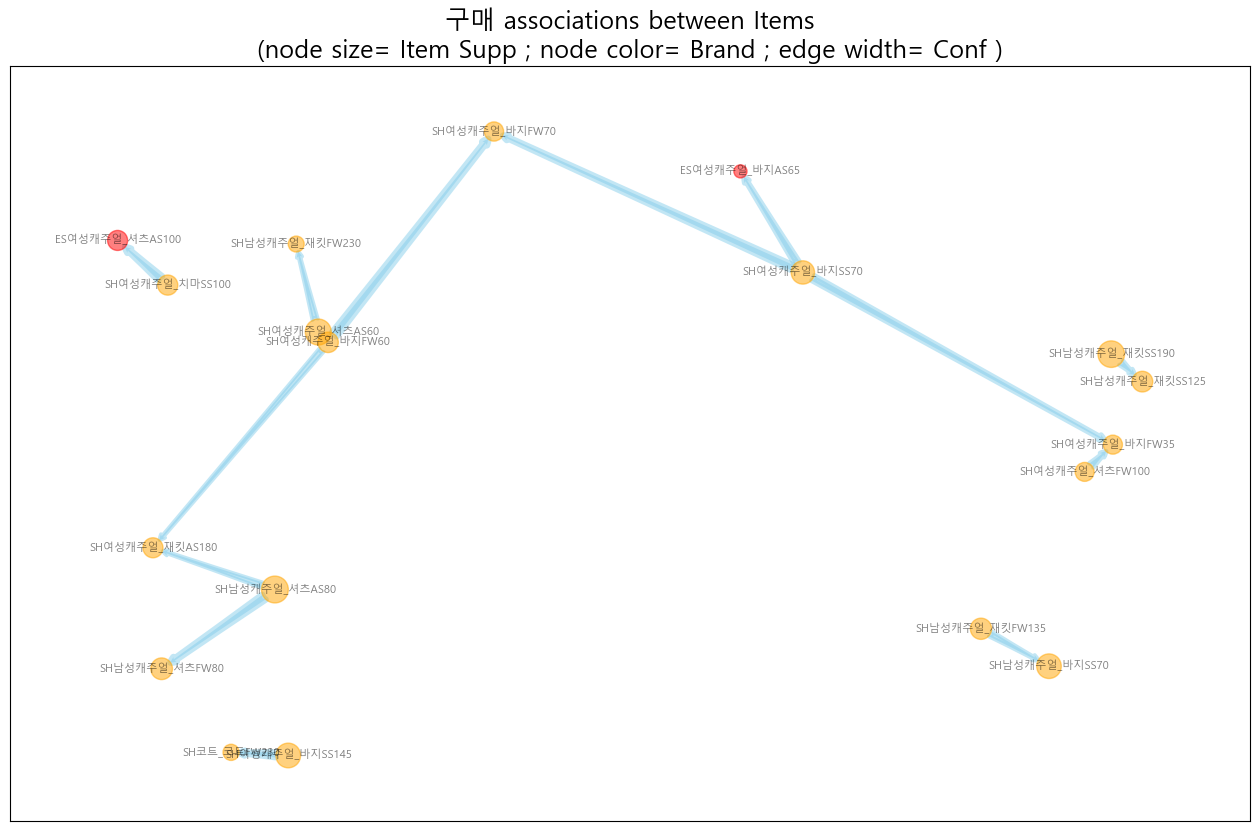

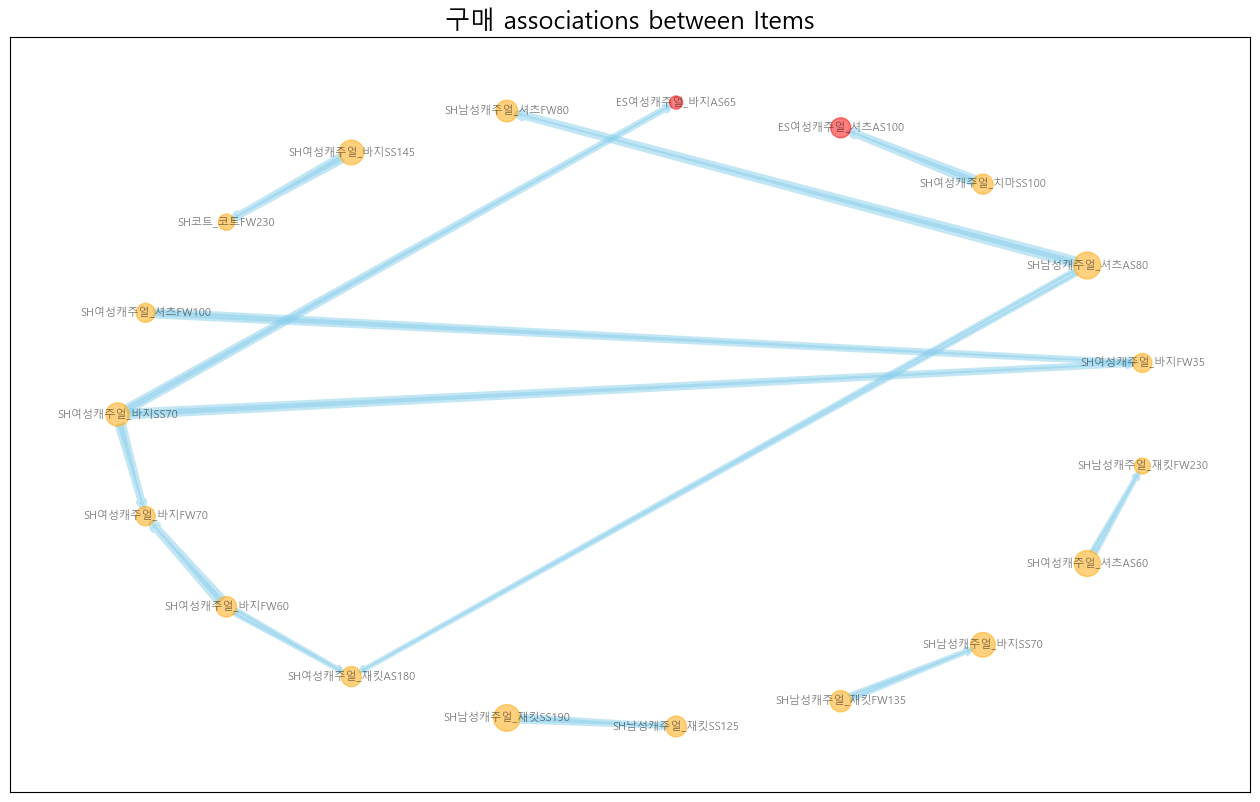

In [15]:
from matplotlib import pylab
from pylab import *
import networkx as nx

ruledf4 = rulsnAtts.sort_values('supp', ascending=False).head(30)
graph = nx.from_pandas_edgelist(ruledf4, source = 'itemTitle_x', target = 'itemTitle_y', 
                                  edge_attr = 'conf', create_using = nx.DiGraph())

# set colors by item category
gnodes = np.array(graph.nodes)
# print(gnodes)

itemCntdf1 = itemCntdf.merge(dfitemTitle, how='left', on='item_id')
nodesizeList = [itemCntdf1[itemCntdf1.itemTitle==x].recCnt.values[0]*2 for x in gnodes]
# print(nodesizeList)

# 
gnode_types = ['red' if 'ES' in x[:2] else 'orange' for x in gnodes]



plt.figure(figsize = (16,10), dpi=100)
pylab.title('구매 associations between Items\n(node size= Item Supp ; node color= Brand ; edge width= Conf )', size=18)
nx.draw_networkx(graph, node_color=gnode_types, edge_color='skyblue',
                 font_size=8, font_family=font_name, # 한글 사용시 미리 확인한 폰트 명 지정 필요
                 alpha=0.5, 
                 node_size=nodesizeList,
                 # node_size=10,
                 width = np.array(ruledf4.conf*5/ruledf4.conf.max()),
                 arrowstyle='fancy',
                 pos=nx.spring_layout(graph) ) 
plt.show()


plt.figure(figsize = (16,10), dpi=100)
pylab.title('구매 associations between Items', size=18)      
nx.draw_networkx(graph, node_color=gnode_types, edge_color='skyblue',
                 font_size=8, 
                 font_family=font_name, # 한글 사용시 미리 확인한 폰트 명 지정 필요
                 alpha=0.5, 
                 node_size=nodesizeList, 
                 width = np.array(ruledf4.conf*5/ruledf4.conf.max()),
                 arrowstyle='fancy',
                 pos=nx.shell_layout(graph)
                )

# 네트워크 시각화 참고 자료
# https://qxf2.com/blog/drawing-weighted-graphs-with-networkx/ 

# png 이미지 파일로 저장
# plt.savefig(dataPath + "fig_arm_001.png", format = "png", dpi = 400)

plt.show()

In [16]:
# 남성캐주얼 고가 셔츠 구매 고객은 다른 고가 남성 셔츠 뿐 아니라 여성 재킷을 구매할 가능성도 높은 편

rulsnAtts[rulsnAtts.itemTitle_x.str.contains('남성캐주얼_셔츠')]

,ante,cnsq,conf,supp,lift,item_id_x,itemTitle_x,item_id_y,itemTitle_y
4,SH10078,SH10056,11.7,0.11,3.10,SH10078,SH남성캐주얼_셔츠AS80,SH10056,SH남성캐주얼_셔츠FW80
10,SH10034,SH10019,7.6,0.14,3.37,SH10034,SH남성캐주얼_셔츠AS80,SH10019,SH여성캐주얼_재킷AS180


In [17]:
# 중간가격대의 SH 바지 구매 고객은 다양한 여성 바지 구매 가능성 높음
# ES 브랜드 바지도 구매

rulsnAtts[rulsnAtts.itemTitle_x.str.contains('SH여성캐주얼_바지SS70')]

,ante,cnsq,conf,supp,lift,item_id_x,itemTitle_x,item_id_y,itemTitle_y
2,SH10030,ES20011,13.3,0.11,4.81,SH10030,SH여성캐주얼_바지SS70,ES20011,ES여성캐주얼_바지AS65
3,SH10069,SH10041,12.1,0.22,3.05,SH10069,SH여성캐주얼_바지SS70,SH10041,SH여성캐주얼_바지FW70
8,SH10030,SH10024,9.2,0.14,3.34,SH10030,SH여성캐주얼_바지SS70,SH10024,SH여성캐주얼_바지FW35
9,SH10023,SH10013,8.4,0.14,3.06,SH10023,SH여성캐주얼_바지SS70,SH10013,SH여성캐주얼_바지FW35


## 겨울시즌(계절별) 상품군단위 영수증별 연관성 분석

### 데이터 준비

- 영수증 단위 분석에서는 고객번호가 아닌 한 영수증이 단위가 되므로
- 같은 영수증내에 복수의 상품이 함께 담겨있을 가능성을 찾아내는 것임

In [18]:
# 연관성 규칙 생성을 위해 list format (i.e. wide format)으로 변환
# apriori 알고리즘이 요구하는 형식으로

# 2020년 10~12월 겨울시즌 데이터만 사용 
sa1 = sales[(sales.datea>='2020-10-01') & (sales.datea<='2020-12-31')] 
sa1['itemCat'] = sa1.lcat + '_' +sa1.scat + (sa1.unit_prc/1000).astype(int).astype(str)
print(sa1.shape)

# 영수증 번호 & 상품군 기준
sa3 = sa1[['ord_id','itemCat']]

# 최소한의 빈도가 있는 상품으로 분석대상 한정
itemCntdf = cntnpcnt(sa3.itemCat) # 사용자정의함수로 상품별 빈도 집계
frqItems = itemCntdf[itemCntdf.recCnt>1].itemCat
print(len(frqItems))
sa3 = sa3[sa3.itemCat.isin(frqItems)]

# 구매한 상품이 하나 뿐이라면 다른 상품과의 연관성 도출에는 무의미하므로 해당 영수증 제외
tmpsa3ords = sa3[['ord_id','itemCat']].drop_duplicates().groupby('ord_id').count().reset_index()
sa3 = sa3[sa3.ord_id.isin(tmpsa3ords[tmpsa3ords.itemCat>1].ord_id)]
sa3


(5501, 20)
55


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7560\261999868.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sa1['itemCat'] = sa1.lcat + '_' +sa1.scat + (sa1.unit_prc/1000).astype(int).astype(str)


,ord_id,itemCat
1104,300013806,남성캐주얼_셔츠70
1105,300013806,여성캐주얼_바지60
1655,300020829,여성캐주얼_바지70
1656,300020829,여성캐주얼_치마70
1819,300022671,여성캐주얼_바지70
...,...,...
41919,300599643,여성캐주얼_바지130
41926,300599811,여성캐주얼_바지100
41927,300599811,여성캐주얼_바지60
41931,300599886,여성캐주얼_바지70


In [19]:

# 영수증별 구매상품 리스트를 저장할 빈 리스트
tmparr = []
# 영수증리스트
uords = list(sa3.ord_id.unique())
# 영수증수
numords = len(uords)

# 영수증건별로 구매상품 리스트를 추가
for x in uords:
    tmpord_items = list(sa3[sa3.ord_id==x].itemCat.values)
    tmparr.append(tmpord_items)
    
# Check the formatted
print(np.array(tmparr).shape)

# 저장이 정상적으로 되었는지 일부 확인
np.array(tmparr[:10])

(251,)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7560\2819016232.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(np.array(tmparr).shape)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7560\2819016232.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(tmparr[:10])


array([list(['남성캐주얼_셔츠70', '여성캐주얼_바지60']),
       list(['여성캐주얼_바지70', '여성캐주얼_치마70']),
       list(['여성캐주얼_바지70', '여성캐주얼_바지130']),
       list(['여성캐주얼_치마60', '여성캐주얼_바지35']),
       list(['여성캐주얼_바지35', '남성캐주얼_셔츠80']),
       list(['여성캐주얼_바지35', '여성캐주얼_바지70']),
       list(['남성캐주얼_재킷190', '여성캐주얼_셔츠60']),
       list(['여성캐주얼_셔츠70', '여성캐주얼_치마70']),
       list(['남성캐주얼_셔츠80', '코트_코트230']),
       list(['여성캐주얼_바지135', '남성캐주얼_셔츠80', '남성캐주얼_바지60'])], dtype=object)

In [20]:
# 알고리즘 적용 연관성 규칙 추출

from apyori import apriori

# 규칙추출의 조건(min_support, min_confidence 등의 옵션) 은 다양한 조건을 변경해 보면서
# 해당 분석목적에 맞는 값을 찾아야함
rules = apriori(tmparr, min_support = 0.001, min_confidence = 0.005, max_length = 2,
               min_lift=1.01 )

# Listing the resulting Rules
results = list(rules)

print('생성된 규칙 확인(일부) : \n', results[-3::]) # 마지막 3개 규칙

print("\nnumber of rules : " + str(len(results)) + '\n')
num_rules = len(results)


생성된 규칙 확인(일부) : 
 [RelationRecord(items=frozenset({'여성캐주얼_치마60', '여성캐주얼_재킷135'}), support=0.00398406374501992, ordered_statistics=[OrderedStatistic(items_base=frozenset({'여성캐주얼_재킷135'}), items_add=frozenset({'여성캐주얼_치마60'}), confidence=1.0, lift=8.655172413793103), OrderedStatistic(items_base=frozenset({'여성캐주얼_치마60'}), items_add=frozenset({'여성캐주얼_재킷135'}), confidence=0.034482758620689655, lift=8.655172413793103)]), RelationRecord(items=frozenset({'여성캐주얼_재킷155', '여성캐주얼_치마90'}), support=0.00796812749003984, ordered_statistics=[OrderedStatistic(items_base=frozenset({'여성캐주얼_재킷155'}), items_add=frozenset({'여성캐주얼_치마90'}), confidence=1.0, lift=83.66666666666667), OrderedStatistic(items_base=frozenset({'여성캐주얼_치마90'}), items_add=frozenset({'여성캐주얼_재킷155'}), confidence=0.6666666666666666, lift=83.66666666666666)]), RelationRecord(items=frozenset({'여성캐주얼_치마70', '여성캐주얼_치마60'}), support=0.01593625498007968, ordered_statistics=[OrderedStatistic(items_base=frozenset({'여성캐주얼_치마60'}), items_add=frozenset

In [21]:
column_names = ["ante", "cnsq", "conf","supp","lift"]
ruledf = pd.DataFrame(columns = column_names)

# Print rules one by one
for i in range(num_rules):
    result = results[i]
    # print(result)
    supp = int(result.support*10000)/100
    conf = int(result.ordered_statistics[0].confidence *1000)/10
    lift = int(result.ordered_statistics[0].lift *100)/100,
    ante = ''.join([x+' ' for x in result.ordered_statistics[0].items_add]).strip()
    cnsq = ''.join([x+' ' for x in result.ordered_statistics[0].items_base]).strip()
    
    if ante!='':
        # print max 15 rules
        if i<15:
            print("{ "+str(ante)+ " ==>  " + str(cnsq)  +
                  " } [ conf = " + str(conf) + "%,"+ " supp = "+str(supp)+"%, " +
                  " lift = "+str(list(lift)[0])+"]")        
            
        # insert raws into a container df    
        ruledf.loc[i] = [ante, cnsq, conf, supp, list(lift)[0]]
        # print([ante, cnsq, conf, supp, list(lift)[0]])
    
ruledf.sort_values('lift').tail(20)

{ 남성캐주얼_셔츠145 ==>  남성캐주얼_바지100 } [ conf = 14.2%, supp = 0.39%,  lift = 4.48]
{ 남성캐주얼_셔츠80 ==>  남성캐주얼_바지100 } [ conf = 14.2%, supp = 0.39%,  lift = 1.02]
{ 여성캐주얼_바지100 ==>  남성캐주얼_바지100 } [ conf = 14.2%, supp = 0.39%,  lift = 2.1]
{ 여성캐주얼_바지130 ==>  남성캐주얼_바지100 } [ conf = 14.2%, supp = 0.39%,  lift = 1.7]
{ 여성캐주얼_셔츠60 ==>  남성캐주얼_바지100 } [ conf = 14.2%, supp = 0.39%,  lift = 1.79]
{ 여성캐주얼_재킷250 ==>  남성캐주얼_바지100 } [ conf = 14.2%, supp = 0.39%,  lift = 2.98]
{ 여성캐주얼_치마60 ==>  남성캐주얼_바지100 } [ conf = 14.2%, supp = 0.39%,  lift = 1.23]
{ 여성캐주얼_치마70 ==>  남성캐주얼_바지100 } [ conf = 14.2%, supp = 0.39%,  lift = 1.55]
{ 남성캐주얼_셔츠145 ==>  남성캐주얼_바지60 } [ conf = 16.6%, supp = 0.79%,  lift = 5.22]
{ 남성캐주얼_셔츠70 ==>  남성캐주얼_바지60 } [ conf = 8.3%, supp = 0.39%,  lift = 1.9]
{ 남성캐주얼_셔츠80 ==>  남성캐주얼_바지60 } [ conf = 33.3%, supp = 1.59%,  lift = 2.39]
{ 남성캐주얼_재킷135 ==>  남성캐주얼_바지60 } [ conf = 8.3%, supp = 0.39%,  lift = 3.48]
{ 여성캐주얼_바지130 ==>  남성캐주얼_바지60 } [ conf = 16.6%, supp = 0.79%,  lift = 1.99]
{ 여성캐주얼_바지135 =

,ante,cnsq,conf,supp,lift
117,여성캐주얼_재킷180,여성캐주얼_셔츠60,5.0,0.39,6.27
120,코트_코트250,여성캐주얼_셔츠60,5.0,0.39,6.27
20,남성캐주얼_재킷185,남성캐주얼_바지70,5.2,0.39,6.60
47,코트_코트230,남성캐주얼_셔츠80,2.8,0.39,7.17
55,여성캐주얼_바지90,남성캐주얼_재킷135,16.6,0.39,8.36
122,여성캐주얼_치마60,여성캐주얼_재킷135,100.0,0.39,8.65
92,여성캐주얼_셔츠100,여성캐주얼_바지59,50.0,0.39,8.96
17,코트_코트200,남성캐주얼_바지60,8.3,0.39,10.45
115,코트_코트185,여성캐주얼_셔츠35,4.3,0.39,10.91
23,여성캐주얼_셔츠135,남성캐주얼_바지70,5.2,0.39,13.21


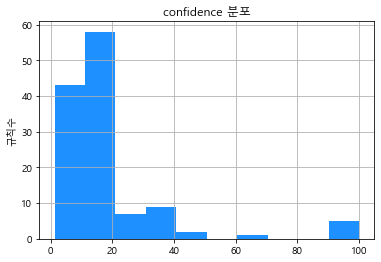

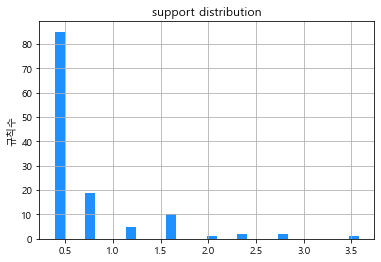

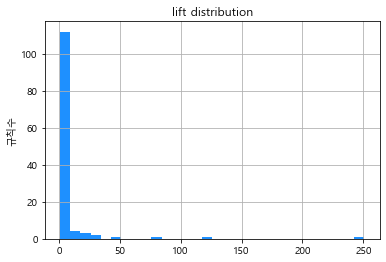

In [22]:
ruledf.conf.hist(bins=10, color='dodgerblue')
plt.title('confidence 분포')
plt.ylabel('규칙수')
plt.show()

ruledf.supp.hist(bins=30, color='dodgerblue')
plt.title('support distribution')
plt.ylabel('규칙수')
plt.show()

ruledf.lift.hist(bins=30, color='dodgerblue')
plt.title('lift distribution')
plt.ylabel('규칙수')
plt.show()

In [23]:
# 전체중 중요도 높은 관심있는 범위의 규칙만 추출

ruledfSub = ruledf[(ruledf.conf>10) & (ruledf.supp>0.5) & (ruledf.lift>1)].sort_values('lift')
ruledfSub 

,ante,cnsq,conf,supp,lift
116,여성캐주얼_셔츠70,여성캐주얼_셔츠60,20.0,1.59,1.02
44,여성캐주얼_셔츠70,남성캐주얼_셔츠80,20.0,2.78,1.02
74,여성캐주얼_바지35,여성캐주얼_바지130,19.0,1.59,1.03
103,여성캐주얼_치마60,여성캐주얼_바지70,12.1,3.58,1.05
95,여성캐주얼_셔츠70,여성캐주얼_바지60,22.2,2.39,1.13
29,여성캐주얼_바지70,남성캐주얼_셔츠110,33.3,0.79,1.13
78,여성캐주얼_바지70,여성캐주얼_바지135,33.3,1.19,1.13
97,여성캐주얼_치마70,여성캐주얼_바지60,11.1,1.19,1.21
75,여성캐주얼_셔츠70,여성캐주얼_바지130,23.8,1.99,1.21
38,여성캐주얼_바지70,남성캐주얼_셔츠70,36.3,1.59,1.23


In [24]:
len(ruledfSub) # 추출된 규칙은 35개

35

In [25]:
# 음의 방향의 연관성을 파악하는 경우 (즉, Lift가 1 보다 작은 규칙들 추출)
# 음의 규칙도 추출하려면 min_lift 조건을 1 보다 작은 값을 허용하는 것으로 변경 필요

# ruledfSub1 = ruledf[(ruledf.conf>0.5) & (ruledf.supp>0.05) & (ruledf.lift<0.5)].sort_values('conf')
# ruledfSub1

- 음의 방향의 Lift도 중요한 정보가 될 수 있음
- 예: 중간가격대 여성바지를 구매하는 고객은 고가 남성셔츠는 구매하지 않는다

### 연관성규칙 네트워크 시각화

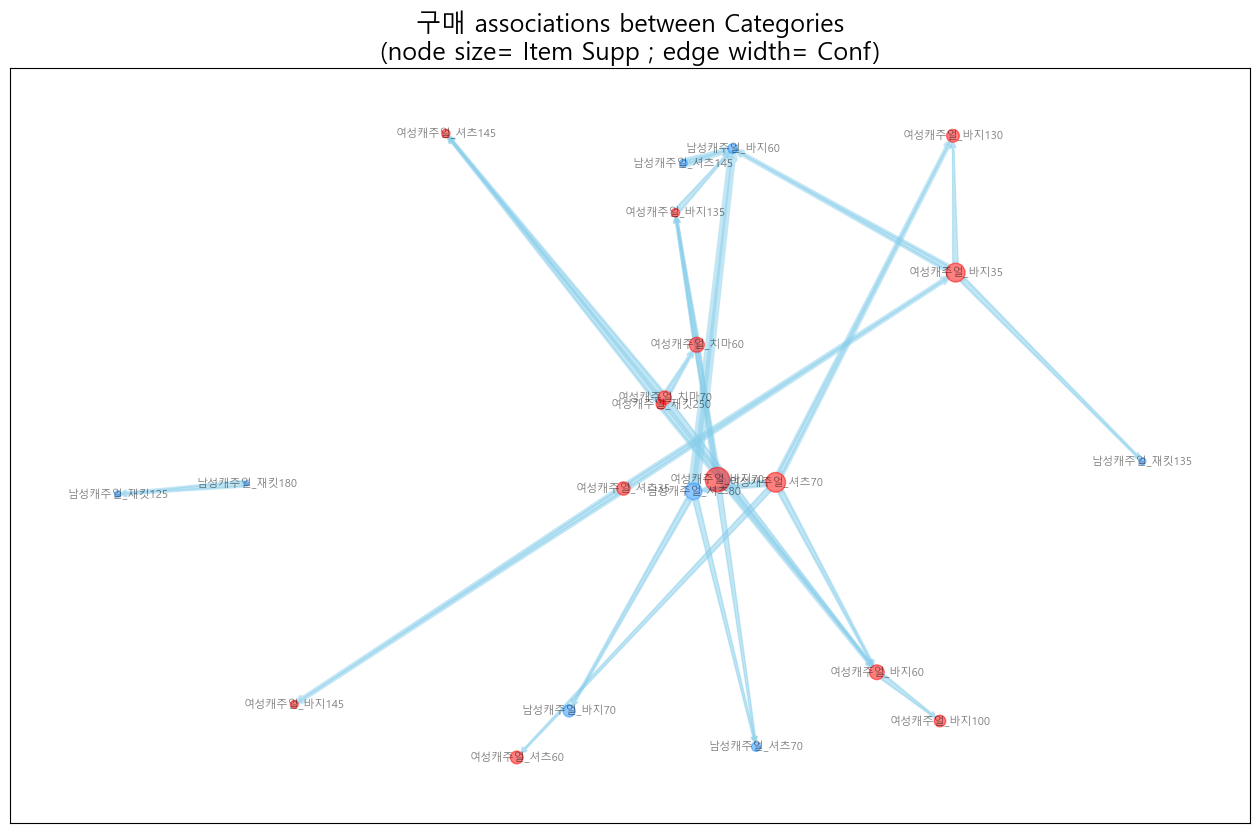

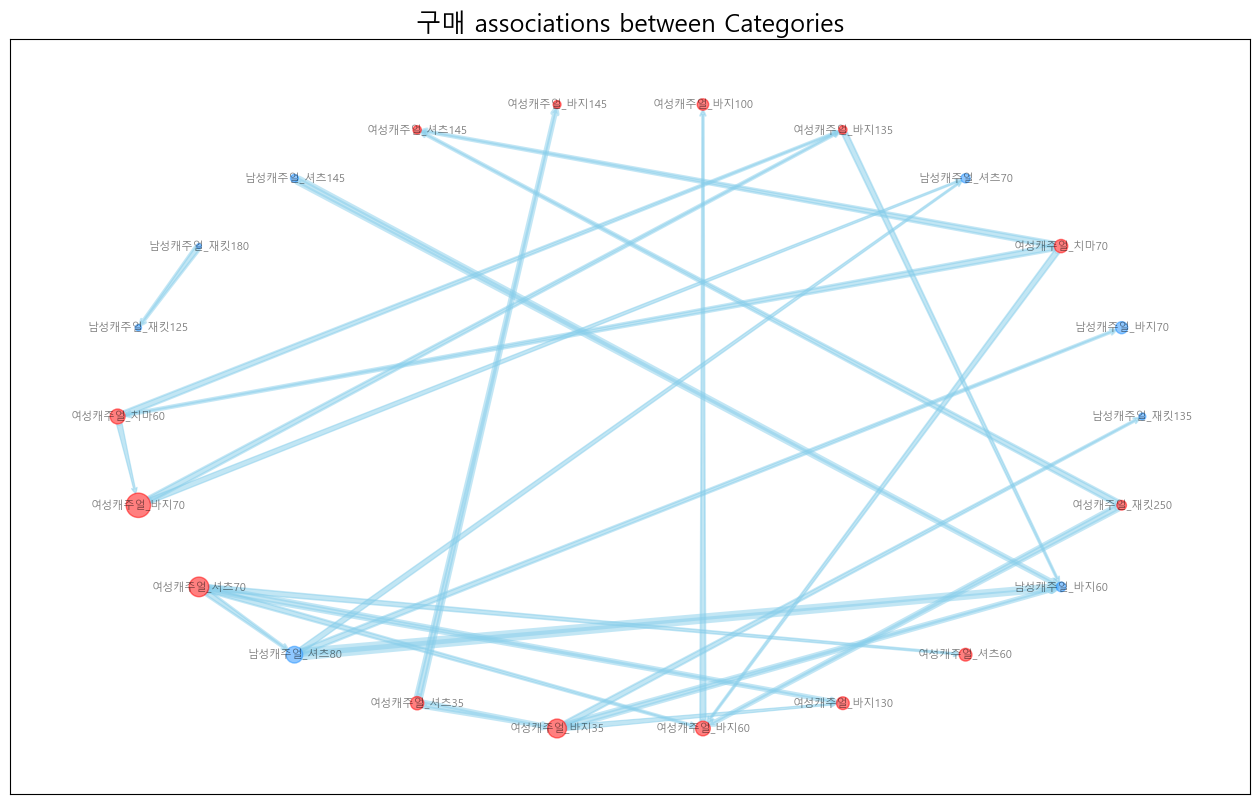

In [26]:
from matplotlib import pylab
from pylab import *
import networkx as nx

ruledf4 = ruledfSub.sort_values('supp', ascending=False).head(25)
graph = nx.from_pandas_edgelist(ruledf4, source = 'ante', target = 'cnsq', 
                                  edge_attr = 'conf', create_using = nx.DiGraph())

# set colors by item category
gnodes = np.array(graph.nodes)
# print(gnodes)

itemCntdf = cntnpcnt(sa3.itemCat)
nodesizeList = [itemCntdf[itemCntdf.itemCat==x].recCnt.values[0]*4 for x in gnodes]
# print(nodesizeList)

# 상품유형을 색상으로 구분
gnode_types = ['dodgerblue' if '남성' in x[:2] else x for x in gnodes]
gnode_types = ['grey' if '코트' in x[:2] else x for x in gnode_types]
gnode_types = ['red' if '여성' in x[:2] else x for x in gnode_types]



plt.figure(figsize = (16,10), dpi=100)
pylab.title('구매 associations between Categories\n(node size= Item Supp ; edge width= Conf)', size=18)
nx.draw_networkx(graph, node_color=gnode_types, edge_color='skyblue',
                 font_size=8, font_family=font_name, # 한글 사용시 미리 확인한 폰트 명 지정 필요
                 alpha=0.5, 
                 node_size=nodesizeList,
                 # node_size=10,
                 width = np.array(ruledf4.conf*5/ruledf4.conf.max()),
                 arrowstyle='fancy',
                 pos=nx.spring_layout(graph) ) 
plt.show()


plt.figure(figsize = (16,10), dpi=100)
pylab.title('구매 associations between Categories', size=18)      
nx.draw_networkx(graph, node_color=gnode_types, edge_color='skyblue',
                 font_size=8, 
                 font_family=font_name, # 한글 사용시 미리 확인한 폰트 명 지정 필요
                 alpha=0.5, 
                 node_size=nodesizeList, 
                 width = np.array(ruledf4.conf*5/ruledf4.conf.max()),
                 arrowstyle='fancy',
                 pos=nx.shell_layout(graph)
                )

# 네트워크 시각화 참고 자료
# https://qxf2.com/blog/drawing-weighted-graphs-with-networkx/ 

# png 이미지 파일로 저장
# plt.savefig(dataPath + "fig_arm_001.png", format = "png", dpi = 400)

plt.show()

In [27]:
# 여성캐주얼의 바지를 구매하는 고객들은 같은 날 다른 여성 바지 또는 다양한 남성캐주얼 함께 구매할 가능성 높음

# 규칙 데이터프레임에서 조건부 상품군명에 지정한 키워드를 포함한 규칙리스트 추출
ruledf4[ruledf4.ante.str.contains('여성캐주얼_바지')]

,ante,cnsq,conf,supp,lift
54,여성캐주얼_바지35,남성캐주얼_재킷135,66.6,1.59,3.63
38,여성캐주얼_바지70,남성캐주얼_셔츠70,36.3,1.59,1.23
74,여성캐주얼_바지35,여성캐주얼_바지130,19.0,1.59,1.03
78,여성캐주얼_바지70,여성캐주얼_바지135,33.3,1.19,1.13
69,여성캐주얼_바지60,여성캐주얼_바지100,17.6,1.19,1.64
15,여성캐주얼_바지35,남성캐주얼_바지60,25.0,1.19,1.36
13,여성캐주얼_바지135,남성캐주얼_바지60,16.6,0.79,4.64


In [28]:
# 남성캐주얼 셔츠를 구매하는 고객들 중에는 같은 날 남성 셔츠를 구매한 경우 뿐 아니라 여성 셔츠나 바지를 구매한 경우 많음
# --> 남녀가 함께 쇼핑을 하거나 남성용 상품을 여성이 구매하는 경우가 많을 가능성 

# 규칙 데이터프레임에서 결과부 상품군명에 지정한 키워드를 포함한 규칙리스트 추출
ruledf4[ruledf4.cnsq.str.contains('남성캐주얼_셔츠')]

,ante,cnsq,conf,supp,lift
44,여성캐주얼_셔츠70,남성캐주얼_셔츠80,20.0,2.78,1.02
37,남성캐주얼_셔츠80,남성캐주얼_셔츠70,36.3,1.59,2.60
38,여성캐주얼_바지70,남성캐주얼_셔츠70,36.3,1.59,1.23


In [29]:
# 중간가격대 남성 셔츠를 구매하는 고객들은 바지나 다른 셔츠 등 남성 상품만 함께 구매하는 경우 많음
# 셔츠 1+1 또는 셔츠 구매시 + 바지 할인 등 점포내 남성 타깃의 프로모션 기획 가능해 보임 (겨울 시즌에 적합)

ruledf4[ruledf4.ante.str.contains('남성캐주얼_셔츠80')]

,ante,cnsq,conf,supp,lift
10,남성캐주얼_셔츠80,남성캐주얼_바지60,33.3,1.59,2.39
19,남성캐주얼_셔츠80,남성캐주얼_바지70,21.0,1.59,1.50
37,남성캐주얼_셔츠80,남성캐주얼_셔츠70,36.3,1.59,2.60


## 전체 분석결과 요약

- 중간가격대의 SH 바지 구매 고객은 1년 중 다양한 여성 바지 구매 가능성 높음 --> 상대적으로 규모가 작은 ES브랜드 바지 상품 교차구매 유도 타깃마케팅 캠페인 실시 필요
- 특히, 겨울시즌 Shoote 브랜드 또는 온라인에서 여성 바지 구매 고객에게 남성복 추가 구매 유도 프로모션 가능성 있음
- 겨울시즌 남성 셔츠 1+1 또는 <셔츠+바지> 구매시 할인 등 구매시점 추가구매 유도 프로모션 가능성 있음 (셔츠 매대에 안내물 게시)